In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class Agent:
    def __init__(self, field_height, field_width, pos=None):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 6  # Increased pass speed for larger field
        self.pass_speed_decay = 1
        
        # Use dictionary for Q-table to handle complex state representation
        self.q_table = {}
    
    def get_q_value(self, state, action):
        """Get Q-value, initializing to zero if state-action pair not seen before"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        return self.q_table[state][action]
    
    def update_q_value(self, state, action, value):
        """Update Q-value for a state-action pair"""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_space.n)
        self.q_table[state][action] = value
    
    def policy(self, state, epsilon):
        """Select action using epsilon-greedy policy"""
        if np.random.uniform(0, 1) < epsilon:
            return self.action_space.sample()
        else:
            if state not in self.q_table:
                self.q_table[state] = np.zeros(self.action_space.n)
            return np.argmax(self.q_table[state])

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        else:
            self.position = np.array(self.pos)
        return self.position

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

class FootballEnv(gym.Env):
    def __init__(self, field_height, field_width, agents):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)

        # Observation Space: Handled differently with complex state representation
        self.observation_space = spaces.Discrete(field_height * field_width)

        self.field = np.full((self.field_height, self.field_width), '.', dtype=str)
        self.rewards = np.full((self.field_height, self.field_width), -0.1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.agents = agents
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.pass_attempts = 0
        self.successful_passes = 0
        self.done = False

        self.reset()

    def _get_observation(self, agent_idx):
        """
        Create a comprehensive state representation for an agent that includes:
        - Agent's own position
        - Ball position
        - Ball holder information
        """
        # Calculate individual state features
        agent_pos = self.agents_positions[agent_idx]
        
        # For large fields, we'll use a simplified state representation
        # Encode agent's position relative to the ball rather than absolute position
        ball_rel_x = agent_pos[0] - self.ball_pos[0]
        ball_rel_y = agent_pos[1] - self.ball_pos[1]
        
        # Discretize relative positions to handle large field size
        # Map to ranges like -5 to +5 to keep state space manageable
        ball_rel_x = max(-5, min(5, ball_rel_x))
        ball_rel_y = max(-5, min(5, ball_rel_y))
        
        # Distance to goal (discretized to keep state space manageable)
        goal_dist_x = agent_pos[0] - self.field_height // 2  # Distance to goal center (x-axis)
        goal_dist_y = self.goal_y - agent_pos[1]  # Distance to goal line (y-axis)
        goal_dist_x = max(-5, min(5, goal_dist_x // 10))  # Discretize distance
        goal_dist_y = max(0, min(7, goal_dist_y // 10))  # Discretize distance
        
        # Encode ball holder (add field size to indicate no holder)
        ball_holder_state = -1 if self.ball_holder is None else self.ball_holder
        
        # Encode if ball is in transit
        ball_transit_state = 1 if self.ball_in_transit else 0
        
        # Is this agent the ball holder?
        is_ball_holder = 1 if self.ball_holder == agent_idx else 0
        
        # Combine features into a tuple that can be used as a dictionary key
        state_tuple = (ball_rel_x, ball_rel_y, goal_dist_x, goal_dist_y, 
                       ball_holder_state, ball_transit_state, is_ball_holder)
        
        return state_tuple

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        # Center of the field
        self.ball_pos = np.array([self.field_height // 2, self.field_width // 2])
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.last_passer = None
        self.pass_target = None
        self.done = False
        
        # Initial observations
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, self.ball_pos, self.ball_holder

    def closest_pass(self, ball_holder_idx):
        """Find the best agent to pass to based on position and distance"""
        ball_holder_pos = self.agents_positions[ball_holder_idx]
        
        # Calculate distances to all other agents
        distances = []
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                # Calculate distance
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                
                # Calculate position advantage (prefer agents ahead toward goal)
                position_advantage = 0
                if agent.position[1] > ball_holder_pos[1]:  # Agent is ahead (toward goal)
                    position_advantage = 10  # Strong preference for forward passes
                
                # Calculate score (lower is better - adjust weights as needed)
                score = dist - position_advantage
                
                # Only consider agents at a reasonable passing distance
                # For larger field, increase the reasonable pass distance
                if 5 <= dist <= 20:
                    distances.append((i, score))
        
        # Sort by score and return the best option
        if distances:
            distances.sort(key=lambda x: x[1])
            return distances[0][0]  # Return the index of best agent to pass to
        
        # If no good passing option, find the closest agent as fallback
        closest_idx = -1
        min_dist = float('inf')
        for i, agent in enumerate(self.agents):
            if i != ball_holder_idx:
                dist = np.linalg.norm(agent.position - ball_holder_pos)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = i
        
        return closest_idx

    def calculate_reward(self, agent_idx, old_position, new_position):
        """Calculate rewards based on game situation and agent actions"""
        reward = 0
        
        # Base small negative reward to encourage efficiency
        reward -= 0.1
        
        # If agent has the ball
        if self.ball_holder == agent_idx:
            # Reward for moving toward the goal (but passing is higher priority)
            if new_position[1] > old_position[1]:  # Moving right toward goal
                reward += 0.5
            
            # Check for potential passing opportunities
            pass_target = self.closest_pass(agent_idx)
            if pass_target != -1:
                target_pos = self.agents_positions[pass_target]
                # If there's a good passing lane, encourage passing
                if 5 <= np.linalg.norm(new_position - target_pos) <= 20:
                    reward += 0.8  # Incentivize moving to positions where passing is good
        
        # If agent doesn't have the ball
        else:
            # If ball is free (no one has it) and not in transit
            if self.ball_holder is None and not self.ball_in_transit:
                # Reward for moving toward the ball
                ball_dist_old = np.linalg.norm(old_position - self.ball_pos)
                ball_dist_new = np.linalg.norm(new_position - self.ball_pos)
                if ball_dist_new < ball_dist_old:
                    reward += 0.7
            
            # If ball is in transit - reward for moving to receive position
            elif self.ball_in_transit:
                # If this agent is the target of a pass
                if self.pass_target == agent_idx:
                    # Reward for moving toward the predicted ball landing point
                    if self.ball_trajectory and self.ball_trajectory_index < len(self.ball_trajectory):
                        target_point = self.ball_trajectory[-1]  # Final point in trajectory
                        target_point = np.array(target_point)
                        
                        old_dist = np.linalg.norm(old_position - target_point)
                        new_dist = np.linalg.norm(new_position - target_point)
                        
                        if new_dist < old_dist:
                            reward += 1.5  # Significant reward for moving to receive position
            
            # If teammate has the ball
            elif self.ball_holder is not None:
                holder_pos = self.agents_positions[self.ball_holder]
                
                # Reward for positioning for a pass
                dist_to_holder = np.linalg.norm(new_position - holder_pos)
                
                # Calculate optimal passing distance range (scaled for larger field)
                if 5 <= dist_to_holder <= 20:
                    reward += 0.5
                    
                    # Bonus for being ahead of ball holder (toward goal)
                    if new_position[1] > holder_pos[1]:
                        reward += 0.7
        
        return reward
    
    def step(self, actions):
        rewards = [0] * len(self.agents)
        
        # Store old positions for reward calculation
        old_positions = [agent.position.copy() for agent in self.agents]

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            
                            # Significant rewards for successful passes
                            rewards[i] += 50  # Reward for receiving a pass
                            rewards[self.last_passer] += 150  # Major reward for successful pass
                            
                            self.successful_passes += 1
                            
                            # End episode on successful pass
                            self.done = True
                            
                            # Get observations for return
                            observations = [self._get_observation(i) for i in range(len(self.agents))]
                            return observations, rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False
                # Ball missed - negative reward for passer
                if self.last_passer is not None:
                    rewards[self.last_passer] -= 10  # Penalty for failed pass

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                
                # Check if new position overlaps with another agent
                position_valid = True
                for j, other_agent in enumerate(self.agents):
                    if j != i and np.array_equal(new_position, other_agent.position):
                        position_valid = False
                        break
                
                if position_valid:
                    agent.position = new_position
                    self.agents_positions[i] = new_position

                    # If this agent is holding the ball, update ball position
                    if self.ball_holder == i and not self.ball_in_transit:
                        self.ball_pos = new_position.copy()

                    # If agent moves to a position with the ball on the field
                    if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                        self.ball_holder = i
                        rewards[i] += (20)  # Picking up the ball
                
                # Calculate movement-based rewards
                move_reward = self.calculate_reward(i, old_position, agent.position)
                rewards[i] += move_reward

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    target_agent_index = self.closest_pass(i)
                    
                    if target_agent_index != -1:  # Valid target found
                        target_position = self.agents[target_agent_index].position
                        trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                        self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                        self.ball_trajectory_index = 0

                        self.ball_in_transit = True
                        self.ball_transit_speed = pass_speed
                        self.ball_transit_direction = pass_direction
                        self.last_passer = i  # Store who made the pass
                        self.pass_target = target_agent_index  # Store the intended receiver
                        self.ball_holder = None
                        self.pass_attempts += 1
                        
                        # Small immediate reward for attempting pass
                        rewards[i] += 10

            elif action == 9:  # Stay still
                # Small reward for staying still if waiting to receive a pass
                if self.ball_in_transit and self.pass_target == i:
                    rewards[i] += 0.5

        # Get observations after all actions
        observations = [self._get_observation(i) for i in range(len(self.agents))]
        
        return observations, rewards, self.done, {}

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.1, gamma=0.95, alpha=0.1, print_frequency=100):
        # Epsilon decay
        epsilon_decay = (epsilon_start - epsilon_end) / (episodes * 0.8)  # Decay over 80% of episodes
        epsilon = epsilon_start
        
        episode_rewards_history = []
        pass_success_rate_history = []
        
        for episode in range(episodes):
            # Reset the environment
            observations, _, _ = self.reset()
            
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                # Select actions using the policy
                actions = [agent.policy(observations[i], epsilon) for i, agent in enumerate(self.agents)]
                
                # Take actions in the environment
                next_observations, rewards, done, _ = self.step(actions)
                
                # Update Q-values using Q-learning
                for i, agent in enumerate(self.agents):
                    # Current Q-value
                    current_q = agent.get_q_value(observations[i], actions[i])
                    
                    # Calculate max future Q-value
                    next_max_q = max([agent.get_q_value(next_observations[i], a) 
                                     for a in range(agent.action_space.n)])
                    
                    # Q-learning update formula
                    new_q = current_q + alpha * (rewards[i] + gamma * next_max_q - current_q)
                    
                    # Update Q-value
                    agent.update_q_value(observations[i], actions[i], new_q)
                    
                    total_rewards[i] += rewards[i]
                
                # Update observations
                observations = next_observations
                steps += 1
            
            # Decay epsilon
            if epsilon > epsilon_end:
                epsilon -= epsilon_decay
            
            # Track metrics
            episode_rewards_history.append(sum(total_rewards))
            
            # Calculate pass success rate if attempts were made
            success_rate = 0
            if self.pass_attempts > 0:
                success_rate = self.successful_passes / self.pass_attempts
            pass_success_rate_history.append(success_rate)
            
            # Print progress
            if (episode + 1) % print_frequency == 0 or episode == episodes - 1:
                print(f"Episode {episode + 1}/{episodes}, "
                      f"Total Rewards: {sum(total_rewards):.1f}, "
                      f"Steps: {steps}, "
                      f"Epsilon: {epsilon:.3f}, "
                      f"Pass Success: {self.successful_passes}/{self.pass_attempts} ({success_rate*100:.1f}%)")
                
                # Reset success counter for next reporting period
                self.pass_attempts = 0
                self.successful_passes = 0
        
        return episode_rewards_history, pass_success_rate_history

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'
        
        # For large field, just print a subset around the ball
        ball_x, ball_y = self.ball_pos
        view_range = 15  # View range around the ball
        min_x = max(0, ball_x - view_range)
        max_x = min(self.field_height, ball_x + view_range + 1)
        min_y = max(0, ball_y - view_range)
        max_y = min(self.field_width, ball_y + view_range + 1)
        
        view = field_copy[min_x:max_x, min_y:max_y]
        print(f"Field view around ball position ({ball_x}, {ball_y}):")
        print("\n".join(["".join(row) for row in view]) + "\n")

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Instead, show major grid lines every 10 cells
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players (added one more color)
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import time
import gymnasium as gym
from gymnasium import spaces

# Using the previously defined bresenham_line and Agent classes

def train_large_football_system(field_height=70, field_width=120, num_agents=11, episodes=10000, max_steps=1000,
                               learning_rate=0.1, discount_factor=0.95, epsilon_start=0.9, epsilon_end=0.05,
                               print_frequency=500, plot_results=True):
    """
    Train multiple agents in a large football environment using Q-learning.
    
    Args:
        field_height: Height of the football field (70)
        field_width: Width of the football field (120)
        num_agents: Number of agents to train (11)
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        learning_rate: Learning rate (alpha)
        discount_factor: Discount factor (gamma)
        epsilon_start: Starting exploration rate
        epsilon_end: Final exploration rate
        print_frequency: How often to print progress
        plot_results: Whether to plot learning curves
        
    Returns:
        env: Trained environment with agents
        rewards_history: History of rewards during training
        pass_success_history: History of pass success rates
    """
    # Initialize agents at strategic positions across the field
    agents = []
    
    # Define strategic positions for 11 players - formation 4-4-2
    positions = [
        [field_height // 2, 5],                      # Goalkeeper
        [field_height // 6, field_width // 6],       # Defender left
        [field_height // 3, field_width // 6],       # Defender center-left
        [2 * field_height // 3, field_width // 6],   # Defender center-right
        [5 * field_height // 6, field_width // 6],   # Defender right
        [field_height // 6, field_width // 3],       # Midfielder left
        [field_height // 3, field_width // 3],       # Midfielder center-left
        [2 * field_height // 3, field_width // 3],   # Midfielder center-right
        [5 * field_height // 6, field_width // 3],   # Midfielder right
        [field_height // 3, field_width // 2],       # Forward left
        [2 * field_height // 3, field_width // 2]    # Forward right
    ]
    
    for i in range(num_agents):
        agents.append(Agent(field_height, field_width, pos=positions[i]))
    
    # Create environment
    env = FootballEnv(field_height, field_width, agents)
    
    # Modify the reset method of the environment to spawn ball at random positions
    original_reset = env.reset
    
    def random_ball_reset(seed=None, options=None):
        # Call original reset to reset agents
        observations, _, _ = original_reset(seed, options)
        
        # Explicitly place the ball at a random position in the first third of the field
        env.ball_pos = np.array([
            np.random.randint(field_height // 4, 3 * field_height // 4),
            np.random.randint(5, field_width // 3)
        ])
        
        # No agent starts with the ball
        env.ball_holder = None
        env.ball_in_transit = False
        
        # Check if any agent is already at the ball position
        for i, agent_pos in enumerate(env.agents_positions):
            if np.array_equal(agent_pos, env.ball_pos):
                env.ball_holder = i  # This agent starts with the ball
                break
        
        # Return observations
        observations = [env._get_observation(i) for i in range(len(env.agents))]
        return observations, env.ball_pos, env.ball_holder
    
    # Replace the reset method
    env.reset = random_ball_reset
    
    # Train the agents
    print(f"Starting training with {num_agents} agents on a {field_width}x{field_height} field for {episodes} episodes...")
    print("Ball will spawn at random positions in the defensive third for each episode")
    start_time = time.time()
    
    rewards_history, pass_success_history = env.train(
        episodes=episodes,
        max_steps=max_steps,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        gamma=discount_factor,
        alpha=learning_rate,
        print_frequency=print_frequency
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot learning curves if requested
    if plot_results:
        plot_training_results(rewards_history, pass_success_history)
    
    return env, rewards_history, pass_success_history

def evaluate_large_football_system(env, num_episodes=5, max_steps=100, render=True, 
                                  output_gif="large_football_evaluation.gif", random_ball=True):
    """
    Evaluate trained agents in the large football environment.
    
    Args:
        env: Trained FootballEnv instance
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        output_gif: Filename for output GIF (if render=True)
        random_ball: Whether to spawn the ball randomly for each episode
        
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    total_rewards = []
    episode_steps = []
    successful_passes = 0
    total_pass_attempts = 0
    
    # Track ball progression
    initial_ball_y_positions = []
    final_ball_y_positions = []
    
    if render:
        frames = []
        fig, ax = plt.subplots(figsize=(15, 9))  # Larger figure for the bigger field
    
    # If random_ball is True, make sure we're using the modified reset
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function if not already stored
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position in the defensive third
            env.ball_pos = np.array([
                np.random.randint(env.field_height // 4, 3 * env.field_height // 4),
                np.random.randint(5, env.field_width // 3)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    print(f"\nEvaluating agents for {num_episodes} episodes on {env.field_width}x{env.field_height} field...")
    
    for episode in range(num_episodes):
        observations, _, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        
        # Track ball position for progression calculation
        initial_ball_y = env.ball_pos[1]
        initial_ball_y_positions.append(initial_ball_y)
        
        # Track episode-specific pass attempts and successes
        episode_pass_attempts = 0
        episode_successful_passes = 0
        
        print(f"Episode {episode+1}/{num_episodes}")
        print(f"Ball starting position: {env.ball_pos}, Holder: {env.ball_holder}")
        
        while not done and step_count < max_steps:
            # Store current ball position for tracking progression
            current_ball_y = env.ball_pos[1]
            
            # Use the learned policy (no exploration)
            actions = []
            for i, agent in enumerate(env.agents):
                state = observations[i]
                if state in agent.q_table:
                    actions.append(np.argmax(agent.q_table[state]))
                else:
                    # If state not seen during training, choose a reasonable action
                    if env.ball_holder == i:
                        actions.append(0)  # Move right (toward goal)
                    else:
                        # Move toward the ball
                        agent_pos = env.agents_positions[i]
                        ball_pos = env.ball_pos
                        
                        # Calculate direction vector to ball
                        dx = ball_pos[0] - agent_pos[0]
                        dy = ball_pos[1] - agent_pos[1]
                        
                        # Choose movement action based on direction
                        if abs(dx) > abs(dy):
                            # Prioritize vertical movement
                            if dx > 0:
                                actions.append(2)  # Down
                            else:
                                actions.append(6)  # Up
                        else:
                            # Prioritize horizontal movement
                            if dy > 0:
                                actions.append(0)  # Right
                            else:
                                actions.append(4)  # Left
            
            # Take actions in the environment
            next_observations, rewards, done, _ = env.step(actions)
            
            # Update pass tracking
            if hasattr(env, 'pass_attempts_episode'):
                episode_pass_attempts = env.pass_attempts_episode
            else:
                # If not tracking per episode, estimate from total
                episode_pass_attempts = env.pass_attempts
                
            if hasattr(env, 'successful_passes_episode'):
                episode_successful_passes = env.successful_passes_episode
            else:
                # If not tracking per episode, estimate from total
                episode_successful_passes = env.successful_passes
            
            episode_reward += sum(rewards)
            observations = next_observations
            step_count += 1
            
            # Capture frames for GIF if rendering
            if render:
                frame = render_football_frame(env, ax, fig, episode, step_count)
                frames.append(frame)
            else:
                # Text-based rendering for large field (show area around ball)
                if step_count % 5 == 0:  # Only render every 5 steps to save console space
                    print(f"Step {step_count}:")
                    env.render()
        
        # Record final ball position for progression calculation
        final_ball_y = env.ball_pos[1]
        final_ball_y_positions.append(final_ball_y)
        
        total_rewards.append(episode_reward)
        episode_steps.append(step_count)
        successful_passes += env.successful_passes
        total_pass_attempts += env.pass_attempts
        
        # Add one final frame
        if render and not done:
            frame = render_football_frame(env, ax, fig, episode, step_count, done=True)
            frames.append(frame)
            
            # Add pause between episodes
            for _ in range(10):
                frames.append(frame)
    
    # Calculate evaluation metrics
    avg_reward = sum(total_rewards) / num_episodes if num_episodes > 0 else 0
    avg_steps = sum(episode_steps) / num_episodes if num_episodes > 0 else 0
    pass_success_rate = successful_passes / total_pass_attempts if total_pass_attempts > 0 else 0
    avg_passes_per_episode = total_pass_attempts / num_episodes if num_episodes > 0 else 0
    
    # Calculate ball progression rate
    # Average distance the ball moved toward the goal, normalized by field width
    progression_distances = [final_y - initial_y for initial_y, final_y in 
                           zip(initial_ball_y_positions, final_ball_y_positions)]
    avg_progression = sum(progression_distances) / num_episodes if num_episodes > 0 else 0
    # Calculate the progression rate as a percentage of field width
    ball_progression_rate = (avg_progression / env.field_width) * 100 if env.field_width > 0 else 0
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Pass Success Rate: {successful_passes}/{total_pass_attempts} ({pass_success_rate*100:.1f}%)")
    print(f"Average Passes per Episode: {avg_passes_per_episode:.2f}")
    print(f"Ball Progression Rate: {ball_progression_rate:.1f}% of field width")
    
    # Save GIF if rendering
    if render and frames:
        print(f"Creating evaluation GIF with {len(frames)} frames...")
        frames_pil = [Image.fromarray(frame) for frame in frames]
        frames_pil[0].save(
            output_gif,
            save_all=True,
            append_images=frames_pil[1:],
            optimize=False,
            duration=200,  # milliseconds per frame
            loop=0  # 0 means loop forever
        )
        print(f"Evaluation GIF saved as {output_gif}")
    
    # Restore original reset function if we modified it for evaluation
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    # Return metrics
    metrics = {
        'avg_reward': avg_reward,
        'avg_steps': avg_steps,
        'pass_success_rate': pass_success_rate,
        'total_passes': total_pass_attempts,
        'successful_passes': successful_passes,
        'avg_passes_per_episode': avg_passes_per_episode,
        'ball_progression_rate': ball_progression_rate
    }
    
    return metrics

def render_football_frame(env, ax, fig, episode, step, done=False):
    """
    Render a single frame of the football environment.
    
    Args:
        env: Football environment
        ax: Matplotlib axis
        fig: Matplotlib figure
        episode: Current episode number
        step: Current step number
        done: Whether the episode is done
        
    Returns:
        frame: Rendered frame as numpy array
    """
    # Clear the axis
    ax.clear()
    
    # Create a checkerboard pattern for the field
    field_pattern = np.zeros((env.field_height, env.field_width))
    for i in range(env.field_height):
        for j in range(env.field_width):
            field_pattern[i, j] = (i + j) % 2
    
    # Display the field with a green colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#8BBF73', '#9BCF83'])  # Light green colors
    ax.imshow(field_pattern, cmap=cmap, origin='upper')
    
    # Add grid - for large fields, don't show all grid lines
    # Instead, show major grid lines every 10 cells
    ax.set_xticks(np.arange(0, env.field_width, 10))
    ax.set_yticks(np.arange(0, env.field_height, 10))
    ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Draw goal area
    import matplotlib.patches as patches
    goal_rect = patches.Rectangle((env.goal_y-0.5, env.field_height//2-10), 1, 20, 
                                 linewidth=2, edgecolor='yellow', facecolor='yellow', alpha=0.3)
    ax.add_patch(goal_rect)
    
    # Agent colors for 11 players
    agent_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 
                   'magenta', 'brown', 'pink', 'olive', 'darkturquoise']
    
    # Plot agents
    for i, pos in enumerate(env.agents_positions):
        agent_label = f"{i+1}"
        if i == env.ball_holder:
            ax.plot(pos[1], pos[0], 'o', markersize=12, color=agent_colors[i % len(agent_colors)], zorder=10)
            ax.plot(pos[1], pos[0], 'o', markersize=8, color='black', zorder=11)  # Ball indicator
        else:
            ax.plot(pos[1], pos[0], 'o', markersize=10, color=agent_colors[i % len(agent_colors)], zorder=10)
        
        ax.text(pos[1], pos[0], agent_label, ha='center', va='center', fontsize=8, 
                color='white', fontweight='bold', zorder=12)
    
    # Plot the ball if it's not with any agent
    if env.ball_holder is None:
        ax.plot(env.ball_pos[1], env.ball_pos[0], 'o', markersize=8, color='black', zorder=11)
    
    # Display ball trajectory if in transit
    if env.ball_in_transit and env.ball_trajectory:
        # Only show remaining trajectory
        remaining_traj = env.ball_trajectory[env.ball_trajectory_index:]
        if remaining_traj:
            traj_x = [p[1] for p in remaining_traj]  # y-coordinate for plotting
            traj_y = [p[0] for p in remaining_traj]  # x-coordinate for plotting
            ax.plot(traj_x, traj_y, 'k--', alpha=0.5, zorder=5)
            # Add arrow to show direction
            if len(traj_x) > 1:
                ax.annotate('', xy=(traj_x[-1], traj_y[-1]), 
                          xytext=(traj_x[0], traj_y[0]),
                          arrowprops=dict(arrowstyle='->', color='black', lw=1.5), zorder=6)
    
    # Add episode/step info
    status = "Complete!" if done else f"Step {step}"
    ax.set_title(f"Episode {episode+1}, {status}\n"
                f"Ball holder: {'None' if env.ball_holder is None else f'Agent {env.ball_holder+1}'}")
    
    # Add caption explaining the current state
    status_text = ""
    if env.ball_in_transit:
        status_text = "Ball in transit"
        if hasattr(env, 'last_passer') and env.last_passer is not None:
            status_text += f" (from Agent {env.last_passer+1})"
    elif env.ball_holder is not None:
        status_text = f"Agent {env.ball_holder+1} has the ball"
    else:
        status_text = "Ball is free"
        
    ax.text(env.field_width/2, -5, status_text, ha='center', fontsize=12)
    
    # Capture the frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return frame

def plot_training_results(rewards_history, pass_success_history):
    """
    Plot the training progress metrics.
    
    Args:
        rewards_history: List of episode rewards
        pass_success_history: List of pass success rates
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Smooth the rewards for better visualization
    window_size = min(100, len(rewards_history) // 10)
    if window_size < 1:
        window_size = 1
    
    smoothed_rewards = []
    for i in range(len(rewards_history)):
        start_idx = max(0, i - window_size)
        end_idx = min(len(rewards_history), i + window_size + 1)
        smoothed_rewards.append(sum(rewards_history[start_idx:end_idx]) / (end_idx - start_idx))
    
    episodes = range(1, len(rewards_history) + 1)
    
    # Plot rewards
    ax1.plot(episodes, rewards_history, 'b-', alpha=0.3, label='Raw Rewards')
    ax1.plot(episodes, smoothed_rewards, 'r-', label='Smoothed Rewards')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Progress - Large Football Environment (120x70) with 11 players')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pass success rate
    ax2.plot(episodes, pass_success_history, 'g-', label='Pass Success Rate')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('11player_passing_training_progress.png')
    plt.show()

In [ ]:
# Set parameters for large field
field_height = 70
field_width = 120
num_agents = 11  # Updated to 11 players

# Training parameters
training_episodes = 5000  # Reduced from 8000 to balance training time
max_steps_per_episode = 1000  # Increased for larger field

# Train agents
trained_env, rewards_history, pass_success_history = train_large_football_system(
    field_height=field_height,
    field_width=field_width,
    num_agents=num_agents,
    episodes=training_episodes,
    max_steps=max_steps_per_episode,
    epsilon_start=0.9,
    epsilon_end=0.05,
    print_frequency=500,
    plot_results=True
)

Starting training with 11 agents on a 120x70 field for 5000 episodes...
Ball will spawn at random positions in the defensive third for each episode
Episode 500/5000, Total Rewards: 850.6, Steps: 232, Epsilon: 0.794, Pass Success: 498/1497 (33.3%)
Episode 1000/5000, Total Rewards: 412.9, Steps: 58, Epsilon: 0.688, Pass Success: 500/1446 (34.6%)



Evaluating agents for 5 episodes on 120x70 field...
Episode 1/5
Ball starting position: [24 24], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibD

Episode 2/5
Ball starting position: [46 22], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibD

Episode 3/5
Ball starting position: [28  7], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibD

Episode 4/5
Ball starting position: [44  7], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibD

Episode 5/5
Ball starting position: [41 21], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibD


Evaluation Results:
Average Reward: 407.82
Average Steps per Episode: 60.40
Pass Success Rate: 4/6 (66.7%)
Average Passes per Episode: 1.20
Ball Progression Rate: 30.8% of field width
Creating evaluation GIF with 313 frames...
Evaluation GIF saved as 11players_passing.gif


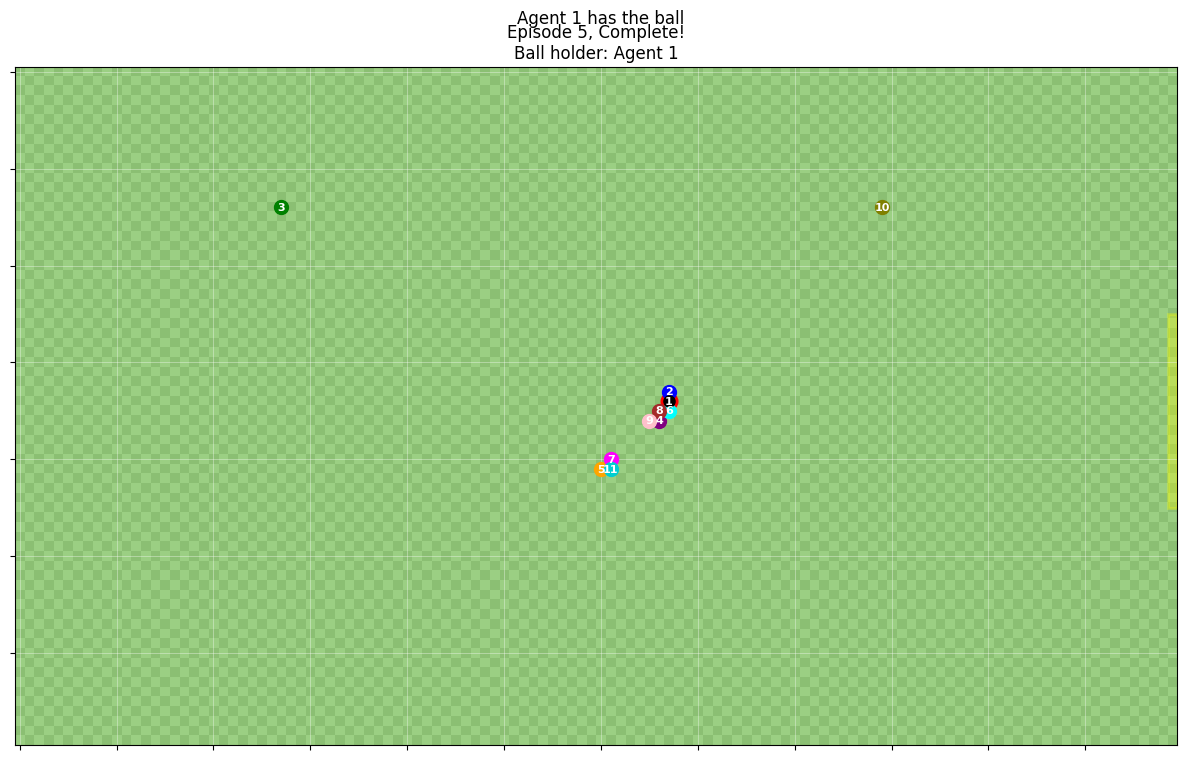

In [ ]:
# Evaluate trained agents
eval_metrics = evaluate_large_football_system(
    env=trained_env,
    num_episodes=5,
    max_steps=150,
    render=True,
    output_gif="11players_passing.gif",
    random_ball=True
)

In [11]:
def evaluate_step_by_step(env, output_folder="step_by_step_frames", max_steps=150, random_ball=True):
    """
    Run a single episode evaluation and save each frame for step-by-step review.
    
    Args:
        env: Trained FootballEnv instance
        output_folder: Folder to save individual step frames
        max_steps: Maximum steps for the episode
        random_ball: Whether to spawn the ball randomly
        
    Returns:
        step_data: Dictionary with data for each step
    """
    import os
    import matplotlib.pyplot as plt
    import time
    import numpy as np
    from PIL import Image
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    print(f"\nRunning step-by-step evaluation (1 episode, max {max_steps} steps)...")
    print(f"Saving frames to folder: {output_folder}")
    
    # If random_ball is True, modify reset function temporarily
    if random_ball and not hasattr(env, '_original_reset'):
        # Store the original reset function
        env._original_reset = env.reset
        
        def random_ball_reset_eval(seed=None, options=None):
            # Call original reset
            observations, _, _ = env._original_reset(seed, options)
            
            # Place ball at random position in the defensive third
            env.ball_pos = np.array([
                np.random.randint(env.field_height // 4, 3 * env.field_height // 4),
                np.random.randint(5, env.field_width // 3)
            ])
            
            # Check if any agent is at the ball position
            env.ball_holder = None
            for i, agent_pos in enumerate(env.agents_positions):
                if np.array_equal(agent_pos, env.ball_pos):
                    env.ball_holder = i
                    break
            
            # Reset other ball-related attributes
            env.ball_in_transit = False
            env.ball_trajectory = []
            env.ball_trajectory_index = 0
            env.pass_attempts = 0
            env.successful_passes = 0
            
            # Get updated observations
            observations = [env._get_observation(i) for i in range(len(env.agents))]
            return observations, env.ball_pos, env.ball_holder
        
        # Replace reset function for evaluation
        env.reset = random_ball_reset_eval
    
    # Create figure for rendering
    fig, ax = plt.subplots(figsize=(15, 9))
    
    # Initialize step data storage
    step_data = {
        'rewards': [],
        'actions': [],
        'ball_pos': [],
        'ball_holder': [],
        'agent_positions': [],
        'ball_in_transit': [],
        'pass_attempts': 0,
        'successful_passes': 0
    }
    
    # Reset environment to start episode
    observations, _, _ = env.reset()
    
    # Log initial state
    step_data['ball_pos'].append(env.ball_pos.copy())
    step_data['ball_holder'].append(env.ball_holder)
    step_data['agent_positions'].append([pos.copy() for pos in env.agents_positions])
    step_data['ball_in_transit'].append(env.ball_in_transit)
    
    # Save initial frame
    frame = render_football_frame(env, ax, fig, 0, 0)
    initial_frame_path = os.path.join(output_folder, f"step_000_initial.png")
    Image.fromarray(frame).save(initial_frame_path)
    
    print(f"Initial state saved: Ball at {env.ball_pos}, Holder: {env.ball_holder}")
    
    # Run the episode
    step_count = 0
    done = False
    total_reward = 0
    
    while not done and step_count < max_steps:
        # Use the learned policy (no exploration)
        actions = []
        for i, agent in enumerate(env.agents):
            state = observations[i]
            if state in agent.q_table:
                actions.append(np.argmax(agent.q_table[state]))
            else:
                # If state not seen during training, choose a reasonable action
                if env.ball_holder == i:
                    actions.append(0)  # Move right (toward goal)
                else:
                    # Move toward the ball
                    agent_pos = env.agents_positions[i]
                    ball_pos = env.ball_pos
                    
                    # Calculate direction vector to ball
                    dx = ball_pos[0] - agent_pos[0]
                    dy = ball_pos[1] - agent_pos[1]
                    
                    # Choose movement action based on direction
                    if abs(dx) > abs(dy):
                        # Prioritize vertical movement
                        if dx > 0:
                            actions.append(2)  # Down
                        else:
                            actions.append(6)  # Up
                    else:
                        # Prioritize horizontal movement
                        if dy > 0:
                            actions.append(0)  # Right
                        else:
                            actions.append(4)  # Left
        
        # Take action in the environment
        next_observations, rewards, done, _ = env.step(actions)
        
        # Increment step count
        step_count += 1
        
        # Update total reward
        step_reward = sum(rewards)
        total_reward += step_reward
        
        # Store step data
        step_data['actions'].append(actions.copy())
        step_data['rewards'].append(rewards.copy())
        step_data['ball_pos'].append(env.ball_pos.copy())
        step_data['ball_holder'].append(env.ball_holder)
        step_data['agent_positions'].append([pos.copy() for pos in env.agents_positions])
        step_data['ball_in_transit'].append(env.ball_in_transit)
        
        # Render and save frame for this step
        frame = render_football_frame(env, ax, fig, 0, step_count, done=done)
        frame_path = os.path.join(output_folder, f"step_{step_count:03d}.png")
        Image.fromarray(frame).save(frame_path)
        
        # Print step info
        action_names = ['Right', 'Down-Right', 'Down', 'Down-Left', 'Left', 'Up-Left', 'Up', 'Up-Right', 'Pass', 'Stay']
        ball_status = "in transit" if env.ball_in_transit else f"with Agent {env.ball_holder+1}" if env.ball_holder is not None else "free"
        
        print(f"Step {step_count}: Ball {ball_status}, Reward: {step_reward:.1f}")
        
        if env.ball_holder is not None:
            holder_idx = env.ball_holder
            holder_action = actions[holder_idx]
            print(f"  Ball holder (Agent {holder_idx+1}) action: {action_names[holder_action]}")
        
        if env.ball_in_transit:
            print(f"  Ball in transit from Agent {env.last_passer+1}, Target: Agent {env.pass_target+1}")
        
        # Update observations for next step
        observations = next_observations
    
    # Save final state if not done already
    if not done:
        frame = render_football_frame(env, ax, fig, 0, step_count, done=True)
        final_frame_path = os.path.join(output_folder, f"step_{step_count+1:03d}_final.png")
        Image.fromarray(frame).save(final_frame_path)
    
    # Create a consolidated visual summary
    create_step_summary(output_folder, step_count)
    
    # Update pass statistics
    step_data['pass_attempts'] = env.pass_attempts
    step_data['successful_passes'] = env.successful_passes
    
    # Print summary
    pass_success_rate = env.successful_passes / env.pass_attempts if env.pass_attempts > 0 else 0
    print("\nStep-by-Step Evaluation Summary:")
    print(f"Total Steps: {step_count}")
    print(f"Total Reward: {total_reward:.2f}")
    print(f"Pass Success: {env.successful_passes}/{env.pass_attempts} ({pass_success_rate*100:.1f}%)")
    print(f"Episode {'completed successfully' if done else 'reached max steps'}")
    print(f"All frames saved to {output_folder} folder")
    
    # Create HTML viewer for easy browsing of steps
    create_html_viewer(output_folder, step_count)
    
    # Restore original reset function
    if random_ball and hasattr(env, '_original_reset'):
        env.reset = env._original_reset
        delattr(env, '_original_reset')
    
    plt.close(fig)
    return step_data

def create_step_summary(output_folder, total_steps, sample_interval=5):
    """Create a visual summary of select steps from the episode"""
    import os
    import matplotlib.pyplot as plt
    from PIL import Image
    import numpy as np
    
    # Choose steps to include (initial, every sample_interval, and final)
    step_files = []
    
    # Initial state
    step_files.append(os.path.join(output_folder, "step_000_initial.png"))
    
    # Sample steps
    for step in range(1, total_steps + 1, sample_interval):
        file_path = os.path.join(output_folder, f"step_{step:03d}.png")
        if os.path.exists(file_path):
            step_files.append(file_path)
    
    # Final state
    final_path = os.path.join(output_folder, f"step_{total_steps+1:03d}_final.png")
    if os.path.exists(final_path):
        step_files.append(final_path)
    else:
        final_path = os.path.join(output_folder, f"step_{total_steps:03d}.png")
        if os.path.exists(final_path):
            step_files.append(final_path)
    
    # Number of images to include
    n_images = len(step_files)
    if n_images == 0:
        print("No step images found to create summary")
        return
    
    # Calculate grid dimensions
    cols = min(5, n_images)
    rows = (n_images + cols - 1) // cols
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Add images to the grid
    for i, file_path in enumerate(step_files):
        if i < len(axes):
            if os.path.exists(file_path):
                img = plt.imread(file_path)
                axes[i].imshow(img)
                step_num = os.path.basename(file_path).split('_')[1]
                if step_num == '000':
                    axes[i].set_title("Initial State")
                elif "final" in file_path:
                    axes[i].set_title(f"Final (Step {step_num})")
                else:
                    axes[i].set_title(f"Step {step_num}")
                axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    summary_path = os.path.join(output_folder, "episode_summary.png")
    plt.savefig(summary_path)
    plt.close(fig)
    print(f"Episode summary image saved to {summary_path}")

def create_html_viewer(output_folder, total_steps):
    """Create an HTML file for easy browsing of step images"""
    import os
    
    html_path = os.path.join(output_folder, "step_viewer.html")
    
    with open(html_path, 'w') as f:
        f.write("""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Football AI Step Viewer</title>
            <style>
                body { font-family: Arial, sans-serif; margin: 0; padding: 20px; background: #f0f0f0; }
                .container { max-width: 1200px; margin: 0 auto; background: white; padding: 20px; border-radius: 5px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }
                h1 { color: #333; }
                .controls { margin-bottom: 20px; display: flex; align-items: center; gap: 10px; }
                input[type="range"] { flex-grow: 1; }
                button { padding: 8px 15px; background: #4CAF50; color: white; border: none; border-radius: 4px; cursor: pointer; }
                button:hover { background: #45a049; }
                .image-container { text-align: center; margin-bottom: 20px; }
                img { max-width: 100%; height: auto; border: 1px solid #ddd; }
                .step-info { font-size: 18px; font-weight: bold; margin-bottom: 10px; }
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Football AI Step-by-Step Viewer</h1>
                <div class="controls">
                    <button id="prevBtn">Previous Step</button>
                    <input type="range" id="stepSlider" min="0" max="0" value="0">
                    <button id="nextBtn">Next Step</button>
                    <span id="stepDisplay">Step: 0</span>
                </div>
                <div class="step-info" id="stepInfo">Initial State</div>
                <div class="image-container">
                    <img id="stepImage" src="" alt="Step visualization">
                </div>
                <div class="controls">
                    <button id="playBtn">Play</button>
                    <button id="pauseBtn">Pause</button>
                    <label for="playSpeed">Speed:</label>
                    <select id="playSpeed">
                        <option value="2000">0.5x</option>
                        <option value="1000" selected>1x</option>
                        <option value="500">2x</option>
                        <option value="250">4x</option>
                    </select>
                </div>
            </div>
            
            <script>
                // Step data
                const totalSteps = """ + str(total_steps) + """;
                const initialImage = "step_000_initial.png";
                
                // Get elements
                const slider = document.getElementById('stepSlider');
                const stepDisplay = document.getElementById('stepDisplay');
                const stepInfo = document.getElementById('stepInfo');
                const stepImage = document.getElementById('stepImage');
                const prevBtn = document.getElementById('prevBtn');
                const nextBtn = document.getElementById('nextBtn');
                const playBtn = document.getElementById('playBtn');
                const pauseBtn = document.getElementById('pauseBtn');
                const speedSelect = document.getElementById('playSpeed');
                
                // Set slider range
                slider.max = totalSteps + 1; // +1 for final frame if available
                
                let currentStep = 0;
                let isPlaying = false;
                let playInterval;
                
                // Initialize with first image
                updateStepDisplay();
                
                // Event listeners
                slider.addEventListener('input', function() {
                    currentStep = parseInt(this.value);
                    updateStepDisplay();
                });
                
                prevBtn.addEventListener('click', function() {
                    if (currentStep > 0) {
                        currentStep--;
                        slider.value = currentStep;
                        updateStepDisplay();
                    }
                });
                
                nextBtn.addEventListener('click', function() {
                    if (currentStep < totalSteps + 1) {
                        currentStep++;
                        slider.value = currentStep;
                        updateStepDisplay();
                    }
                });
                
                playBtn.addEventListener('click', startPlayback);
                pauseBtn.addEventListener('click', stopPlayback);
                
                function startPlayback() {
                    if (isPlaying) return;
                    isPlaying = true;
                    
                    // If at end, restart from beginning
                    if (currentStep >= totalSteps + 1) {
                        currentStep = 0;
                        slider.value = currentStep;
                        updateStepDisplay();
                    }
                    
                    const speed = parseInt(speedSelect.value);
                    playInterval = setInterval(function() {
                        if (currentStep < totalSteps + 1) {
                            currentStep++;
                            slider.value = currentStep;
                            updateStepDisplay();
                        } else {
                            stopPlayback();
                        }
                    }, speed);
                }
                
                function stopPlayback() {
                    if (!isPlaying) return;
                    clearInterval(playInterval);
                    isPlaying = false;
                }
                
                function updateStepDisplay() {
                    let imagePath;
                    let stepText;
                    
                    if (currentStep === 0) {
                        imagePath = initialImage;
                        stepText = "Initial State";
                    } else if (currentStep === totalSteps + 1) {
                        // Check if final image exists, otherwise use last step
                        const finalImagePath = `step_${(currentStep).toString().padStart(3, '0')}_final.png`;
                        imagePath = finalImagePath;
                        stepText = "Final State";
                    } else {
                        imagePath = `step_${currentStep.toString().padStart(3, '0')}.png`;
                        stepText = `Step ${currentStep}`;
                    }
                    
                    stepImage.src = imagePath;
                    stepDisplay.textContent = `Step: ${currentStep}`;
                    stepInfo.textContent = stepText;
                }
            </script>
        </body>
        </html>
        """)
    
    print(f"HTML viewer created at {html_path}")


# Call this function after running the main code to perform the step-by-step evaluation
def run_step_by_step_evaluation(trained_env):
    """Run a step-by-step evaluation of the trained environment"""
    print("\n" + "="*80)
    print("Starting Step-by-Step Evaluation")
    print("="*80)
    
    # Run the step-by-step evaluation
    step_data = evaluate_step_by_step(
        env=trained_env, 
        output_folder="step_by_step_frames",
        max_steps=150,
        random_ball=True
    )
    
    print("\nStep-by-step evaluation complete. Review the frames in the step_by_step_frames folder.")
    print("You can also view the images sequentially using the HTML viewer.")
    
    return step_data

# Run the step-by-step evaluation after the main training and evaluation
step_data = run_step_by_step_evaluation(trained_env)


Starting Step-by-Step Evaluation

Running step-by-step evaluation (1 episode, max 150 steps)...
Saving frames to folder: step_by_step_frames


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Initial state saved: Ball at [51 10], Holder: None


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 1: Ball free, Reward: 6.6


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 2: Ball free, Reward: 6.6


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 3: Ball free, Reward: 5.9


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 4: Ball free, Reward: 6.6


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 5: Ball free, Reward: 5.9


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 6: Ball free, Reward: 5.2


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 7: Ball free, Reward: 4.5


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 8: Ball free, Reward: 5.9


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 9: Ball free, Reward: 5.9


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 10: Ball free, Reward: 5.9


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 11: Ball free, Reward: 4.5


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 12: Ball free, Reward: 5.2


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 13: Ball free, Reward: 3.8


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 14: Ball free, Reward: 5.2


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 15: Ball free, Reward: 3.1


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 16: Ball with Agent 4, Reward: 22.3
  Ball holder (Agent 4) action: Up-Left


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 17: Ball with Agent 4, Reward: 2.7
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 18: Ball with Agent 4, Reward: 2.7
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 19: Ball with Agent 4, Reward: 2.7
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 20: Ball with Agent 4, Reward: 2.6
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 21: Ball with Agent 4, Reward: 3.8
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 22: Ball with Agent 4, Reward: 3.3
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 23: Ball with Agent 4, Reward: 3.4
  Ball holder (Agent 4) action: Up


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 24: Ball in transit, Reward: 10.7
  Ball in transit from Agent 4, Target: Agent 3


C:\Users\Pranaav_Prasad\AppData\Local\Temp\ipykernel_13260\167974959.py:432: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Step 25: Ball with Agent 3, Reward: 200.0
  Ball holder (Agent 3) action: Down-Left
Episode summary image saved to step_by_step_frames\episode_summary.png

Step-by-Step Evaluation Summary:
Total Steps: 25
Total Reward: 335.00
Pass Success: 1/1 (100.0%)
Episode completed successfully
All frames saved to step_by_step_frames folder
HTML viewer created at step_by_step_frames\step_viewer.html

Step-by-step evaluation complete. Review the frames in the step_by_step_frames folder.
You can also view the images sequentially using the HTML viewer.
